In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow_addons as tfa

In [2]:
# Path to train images
train_dir = '../input/plant-seedlings-classification/train/'
train_dir_seg = '../input/plant-seedling-segmented/plant-seedling-segmented/seg_train/'
train_dir_large = '../input/plant-seedling-large/plant-seedlings-large/train-large/'
train_dir_seg_large = '../input/plant-seedling-large/plant-seedlings-large/train-large-seg/'


# Path to test images
test_dir = '../input/plant-seedlings-classification/'
test_dir_seg = '../input/plant-seedling-segmented/plant-seedling-segmented/'

model_dir = '../input/plant-seedling-models/'

In [3]:
train = train_dir_large
test = test_dir

In [4]:
phase = 'train'

nb_epoch     = 40
batch_size   = 16
width        = 299
height       = 299

In [5]:
species_list = ["Black-grass", "Charlock", "Cleavers", "Common Chickweed", "Common wheat", "Fat Hen",
                 "Loose Silky-bent", "Maize", "Scentless Mayweed", "Shepherds Purse", "Small-flowered Cranesbill",
                "Sugar beet"]

In [6]:
def define_generators():
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
        rotation_range=360,
        width_shift_range=0.3,
        height_shift_range=0.3,
        shear_range=0.3,
        zoom_range=0.5,
        vertical_flip=True,
        horizontal_flip=True,
        validation_split=0.1,
    )

    train_generator = train_datagen.flow_from_directory(
        directory=train,
        target_size=(width, height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode="categorical",
        subset='training',
    )

    validation_generator = train_datagen.flow_from_directory(
        directory=train,
        target_size=(width, height),
        batch_size=batch_size,
        color_mode='rgb',
        class_mode="categorical",
        subset='validation',
        shuffle=False
    )

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.efficientnet.preprocess_input)

    test_generator = test_datagen.flow_from_directory(
        directory=test,
        classes=['test'],
        target_size=(width, height),
        batch_size=1,
        color_mode='rgb',
        shuffle=False,
        class_mode='categorical')

    return train_generator, validation_generator, test_generator

In [7]:
from tensorflow import keras
from tensorflow.keras import backend as K

def cosine_decay_with_warmup(global_step,
                             learning_rate_base,
                             total_steps,
                             warmup_learning_rate=0.0,
                             warmup_steps=0,
                             hold_base_rate_steps=0):
    """Cosine decay schedule with warm up period.
    Cosine annealing learning rate as described in:
      Loshchilov and Hutter, SGDR: Stochastic Gradient Descent with Warm Restarts.
      ICLR 2017. https://arxiv.org/abs/1608.03983
    In this schedule, the learning rate grows linearly from warmup_learning_rate
    to learning_rate_base for warmup_steps, then transitions to a cosine decay
    schedule.
    Arguments:
        global_step {int} -- global step.
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.
    Keyword Arguments:
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
    Returns:
      a float representing learning rate.
    Raises:
      ValueError: if warmup_learning_rate is larger than learning_rate_base,
        or if warmup_steps is larger than total_steps.
    """

    if total_steps < warmup_steps:
        raise ValueError('total_steps must be larger or equal to '
                         'warmup_steps.')
    learning_rate = 0.5 * learning_rate_base * (1 + np.cos(
        np.pi *
        (global_step - warmup_steps - hold_base_rate_steps
         ) / float(total_steps - warmup_steps - hold_base_rate_steps)))
    if hold_base_rate_steps > 0:
        learning_rate = np.where(global_step > warmup_steps + hold_base_rate_steps,
                                 learning_rate, learning_rate_base)
    if warmup_steps > 0:
        if learning_rate_base < warmup_learning_rate:
            raise ValueError('learning_rate_base must be larger or equal to '
                             'warmup_learning_rate.')
        slope = (learning_rate_base - warmup_learning_rate) / warmup_steps
        warmup_rate = slope * global_step + warmup_learning_rate
        learning_rate = np.where(global_step < warmup_steps, warmup_rate,
                                 learning_rate)
    return np.where(global_step > total_steps, 0.0, learning_rate)


class WarmUpCosineDecayScheduler(keras.callbacks.Callback):
    """Cosine decay with warmup learning rate scheduler
    """

    def __init__(self,
                 learning_rate_base,
                 total_steps,
                 global_step_init=0,
                 warmup_learning_rate=0.0,
                 warmup_steps=0,
                 hold_base_rate_steps=0,
                 verbose=0):
        """Constructor for cosine decay with warmup learning rate scheduler.
    Arguments:
        learning_rate_base {float} -- base learning rate.
        total_steps {int} -- total number of training steps.
    Keyword Arguments:
        global_step_init {int} -- initial global step, e.g. from previous checkpoint.
        warmup_learning_rate {float} -- initial learning rate for warm up. (default: {0.0})
        warmup_steps {int} -- number of warmup steps. (default: {0})
        hold_base_rate_steps {int} -- Optional number of steps to hold base learning rate
                                    before decaying. (default: {0})
        verbose {int} -- 0: quiet, 1: update messages. (default: {0})
        """

        super(WarmUpCosineDecayScheduler, self).__init__()
        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.global_step = global_step_init
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.hold_base_rate_steps = hold_base_rate_steps
        self.verbose = verbose
        self.learning_rates = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = K.get_value(self.model.optimizer.lr)
        self.learning_rates.append(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = cosine_decay_with_warmup(global_step=self.global_step,
                                      learning_rate_base=self.learning_rate_base,
                                      total_steps=self.total_steps,
                                      warmup_learning_rate=self.warmup_learning_rate,
                                      warmup_steps=self.warmup_steps,
                                      hold_base_rate_steps=self.hold_base_rate_steps)
        K.set_value(self.model.optimizer.lr, lr)
        if self.verbose > 0:
            print('\nBatch %05d: setting learning '
                  'rate to %s.' % (self.global_step + 1, lr))

In [8]:
# define appropriate callbacks
def training_callbacks():
    
    # save best model regularly
    save_best_model = tf.keras.callbacks.ModelCheckpoint(filepath = 'model.h5',
        monitor = 'val_acc', save_best_only = True, verbose = 1)
    
    # reduce learning rate when it stops decreasing
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', factor = 0.4,
                              patience = 3, min_lr = 1e-10, verbose = 1, cooldown = 1)
    
    # stop training early if no further improvement
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor = 'val_loss', min_delta = 1e-2, patience = 6, verbose = 1,
        mode = 'min', baseline = None, restore_best_weights = True
    )
    total_steps=296*nb_epoch
    warmup_lr = WarmUpCosineDecayScheduler(learning_rate_base=0.0001,
                                        total_steps=total_steps,
                                        warmup_learning_rate=0.0,
                                        warmup_steps=0.1*total_steps,
                                        hold_base_rate_steps=0)

    return save_best_model, reduce_lr, early_stopping


In [9]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten

def create_model():
    
    #model_input = tf.keras.layers.Input(shape=(width, height, 3), name='image_input')
    model_main = tf.keras.applications.efficientnet.EfficientNetB3(input_shape=(width, height, 3), include_top=False, weights='imagenet')
    #model_dense1 = tf.keras.layers.Flatten()(model_main.output)
    
    layer = model_main.output
    layer = GlobalAveragePooling2D(name="avg_pool")(layer)
    layer = BatchNormalization()(layer)
    
    layer = Dropout(0.2, name="top_dropout")(layer)
    
    #model_dense1 = tf.keras.layers.Flatten()(layer)

    model_dense2 = tf.keras.layers.Dense(256, activation = 'selu', activity_regularizer=tf.keras.regularizers.l2(1e-5))(layer)
    model_dense2 = BatchNormalization()(model_dense2)
    dropout_2 = tf.keras.layers.Dropout(0.25)(model_dense2)
    model_out = tf.keras.layers.Dense(12, activation="softmax")(dropout_2)

    model = tf.keras.models.Model(model_main.input,  model_out)
    optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999)
    model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model

In [10]:
model = create_model()
model.summary()

2022-04-14 12:47:55.430358: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 12:47:55.528506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 12:47:55.529324: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-14 12:47:55.530512: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

43950080/43941136 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 299, 299, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization[0][0]              
_____________________________

/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [11]:
train_generator, validation_generator, test_generator = define_generators()

if phase == 'train':
    history = model.fit(
        train_generator,
        epochs=nb_epoch,
        steps_per_epoch=train_generator.samples // batch_size,
        validation_data= validation_generator,
        validation_steps=validation_generator.samples // batch_size,
        callbacks = training_callbacks()
    )

Found 10800 images belonging to 12 classes.
Found 1200 images belonging to 12 classes.
Found 794 images belonging to 1 classes.


2022-04-14 12:48:14.433816: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/40


2022-04-14 12:48:28.380261: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


675/675 [==============================] - 512s 729ms/step - loss: 1.1487 - accuracy: 0.6403 - val_loss: 0.3970 - val_accuracy: 0.8675
Epoch 2/40
675/675 [==============================] - 408s 605ms/step - loss: 0.4708 - accuracy: 0.8431 - val_loss: 0.2455 - val_accuracy: 0.9217
Epoch 3/40
675/675 [==============================] - 409s 606ms/step - loss: 0.3594 - accuracy: 0.8794 - val_loss: 0.1990 - val_accuracy: 0.9308
Epoch 4/40
675/675 [==============================] - 411s 608ms/step - loss: 0.2983 - accuracy: 0.9026 - val_loss: 0.1471 - val_accuracy: 0.9508
Epoch 5/40
675/675 [==============================] - 417s 618ms/step - loss: 0.2570 - accuracy: 0.9179 - val_loss: 0.1431 - val_accuracy: 0.9550
Epoch 6/40
675/675 [==============================] - 423s 626ms/step - loss: 0.2454 - accuracy: 0.9214 - val_loss: 0.1443 - val_accuracy: 0.9558
Epoch 7/40
675/675 [==============================] - 426s 630ms/step - loss: 0.2193 - accuracy: 0.9284 - val_loss: 0.1111 - val_accura

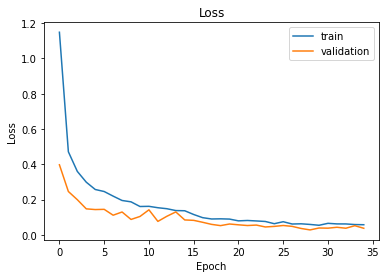

<Figure size 432x288 with 0 Axes>

In [12]:
if phase == 'train':
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label = "validation")
    plt.legend(loc='upper right')
    plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()
    plt.savefig('Loss.png')

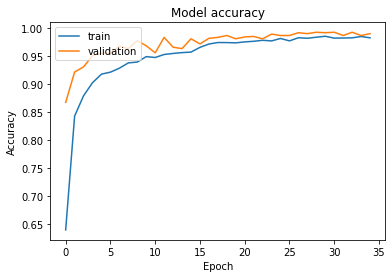

<Figure size 432x288 with 0 Axes>

In [13]:
if phase == 'train':
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label = "validation")
    plt.legend(loc='upper left')
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
    plt.savefig('Accuracy.png')

In [14]:
if phase == 'train':
    model.save_weights('efficientnetB3.h5')

In [15]:
if phase == 'test':
    model.load_weights(f'{model_dir}efficientnetB3.h5')

(1200, 12)


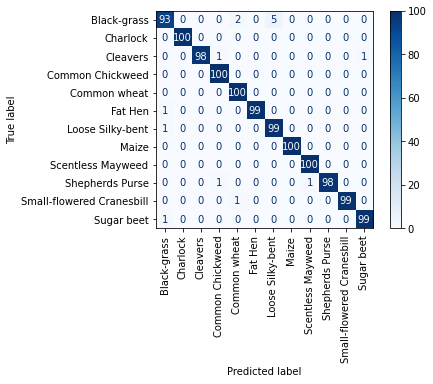

In [16]:
validation_generator.reset() 
val_pred = model.predict(validation_generator, steps=validation_generator.samples)
print(val_pred.shape)
y_pred = np.argmax(val_pred, axis = 1)
y_true = validation_generator.classes

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=species_list)

disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [17]:
predictions = model.predict(test_generator, steps=test_generator.samples)

class_list = []

for i in range(0, predictions.shape[0]):
    y_class = predictions[i, :].argmax(axis=-1)
    class_list += [species_list[y_class]]

submission = pd.DataFrame()
submission['file'] = test_generator.filenames
submission['file'] = submission['file'].str.replace(r'test/', '')
submission['species'] = class_list

submission.to_csv('efficientnetb3_submission.csv', index=False)

print('Submission file generated. All done.')

Submission file generated. All done.
